In [15]:
%matplotlib inline
import pandas as pd
import numpy as np

import csv
import os
import sys

from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.externals import joblib
from sklearn.metrics import log_loss
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# XGBoost params:
xgboost_params = { 
   "objective": "binary:logistic",
   "booster": "gbtree",
   "eval_metric": ["auc","error","map","logloss"],
   "eta": 0.01, # 0.06, #0.01,
   #"min_child_weight": 240,
   "subsample": 0.75,
   "colsample_bytree": 0.68,
   "max_depth": 7,
}

print('Load data...')
train = pd.read_csv('data/train.csv')
target = train['target']
train = train.drop(['ID','target'],axis=1)
test = pd.read_csv('data/test.csv')
ids = test['ID'].values
test = test.drop(['ID'],axis=1)
num_train = train.shape[0]

Load data...


In [3]:
# Define a function, dummify, that will replace categorical features with dummy columns. Return the new dataset,
# the names of the dummy columns, and the rows with null values for each categorical variable
def dummify(name,series):
    prefix_string = name + '_'
    dummies = pd.get_dummies(series,prefix=prefix_string)
    dummy_column_names = dummies.columns.values
    #Get a list of all rows containing nulls. After dummifying these rows will just have all zeros for dummy variable
    get_nulls = np.where(series.isnull() == True)[0].tolist()

    return dummies, dummy_column_names, get_nulls

def fill_nan_null(val):
    ret_fill_nan_null = 0.0
    if val == True:
        ret_fill_nan_null = 1.0
    return ret_fill_nan_null

In [4]:
# Drop features with > 0.9 correlation. Keep feature with fewest NaNs

corr = train.corr()

to_drop = set()
# for col in corr.columns.values:
#     list_correlated = corr[col][(corr[col] > 0.9) & (corr[col] < 1)].index.tolist()
#     if len(list_correlated) > 0:
#         sys.stdout.write(col + ": ")
#         print list_correlated
for col in corr.columns.values:
    if col in to_drop:
        continue

    col_list = corr[col][(corr[col] > 0.9) & (corr[col] < 1)].index.tolist()
    col_set = set(col_list)
    col_set.difference_update(to_drop)
    if (len(col_list) == 0) or (len(col_set) == 0):
        continue

    col_list.append(col)
    lowest_na_count = train[col_list[0]].isnull().sum()
    best_col = col_list[0]
    for option in col_list:
        na_count = train[option].isnull().sum()
        if na_count < lowest_na_count:
            lowest_na_count = na_count
            best_col = option
    col_list.remove(best_col)
#     print 'dropping = ' + str(col_list)
#     print 'keeping = ' + str(best_col)
    to_drop.update(col_list)


In [5]:
print "Adding features..."

train_test_data = pd.concat([train,test],axis=0, ignore_index=True)

train_test_data_types = train_test_data.dtypes[:]


for i in range(len(train_test_data_types)):
    train_test_data[str(train_test_data_types.index[i])+'_nan_'] = train_test_data[str(train_test_data_types.index[i])].map(lambda x:fill_nan_null(pd.isnull(x)))
    
train_test_data['NA_num'] = train_test_data.isnull().sum(axis=1)


Adding features...


In [6]:
drop_correlated = True

if drop_correlated == True:
    print 'Drop Correlated ...'
    train_test_data.drop(list(to_drop),axis=1, inplace = True)

Drop Correlated ...


In [7]:
g = train_test_data.columns.to_series().groupby(train_test_data.dtypes).groups 
g_keys = g.keys()
categorical_columns = g[g_keys[0]]


In [10]:
best_scores = []
for test_var in categorical_columns:
    print'Clearing... ' + test_var 
    train_dummy_columns = {}
    train_nulls_dict = {}
    test_dummy_columns = {}
    test_nulls_dict = {}

    cleaned_train_test_data = train_test_data.copy()

    for (train_name, train_series) in train_test_data.iteritems():
        if (train_name == 'v22') or (train_name == test_var):
            #v22 has too many options to dummify, instead: factorize
            cleaned_train_test_data[train_name], tmp_indexer = pd.factorize(train_test_data[train_name])
            #but now we have -1 values (NaN)    
        elif train_series.dtype == 'O':
            print 'Dummifying ' + train_name
            cleaned_train_test_data.drop(train_name,axis=1,inplace = True)

            train_dummies, train_dummy_list, train_null_list = dummify(train_name,train_series)
            cleaned_train_test_data = pd.concat([cleaned_train_test_data,train_dummies], axis = 1)

            train_dummy_columns[train_name] = train_dummy_list
            train_nulls_dict[train_name] = train_null_list

        else:
            #for int or float: fill NaN
            tmp_len = len(train_test_data[train_series.isnull()])
            if tmp_len>0:
                cleaned_train_test_data.loc[train_series.isnull(), train_name] = train_series.mean()


    train = cleaned_train_test_data.iloc[:num_train]
    test = cleaned_train_test_data.iloc[num_train:]

    X_train, X_valid, y_train, y_valid = train_test_split(train.values, target.values, test_size=0.30, random_state = 1)

    X_valid, X_itest, y_valid, y_itest = train_test_split(X_valid, y_valid, test_size=0.20, random_state = 1)

    final = False

    # xgtrain = xgb.DMatrix(train.values, target.values)
    # xgtest = xgb.DMatrix(test.values)

    xgtrain = xgb.DMatrix(X_train, y_train)
    xgvalid = xgb.DMatrix(X_valid, y_valid)
    xgtest = xgb.DMatrix(test.values)

    #Now let's fit the model
    print('Fit the model...')
    boost_round = 5 #1800 CHANGE THIS BEFORE START

    print 'Training....'
    eval_dict = dict()

    clf = xgb.train(xgboost_params, xgtrain, num_boost_round=boost_round, verbose_eval=50, maximize=False,
                    evals_result=eval_dict, early_stopping_rounds=100, evals=[(xgvalid, 'valid')])

    print 'best score for ' + test_var + ' is ' + str(clf.best_score)
    best_scores.append(clf.best_score)




Clearing... v3
Dummifying v24
Dummifying v30
Dummifying v31
Dummifying v47
Dummifying v52
Dummifying v56
Dummifying v66
Dummifying v71
Dummifying v74
Dummifying v75
Dummifying v79
Dummifying v91
Dummifying v107
Dummifying v110
Dummifying v112
Dummifying v113
Dummifying v125
Fit the model...
Training....


Will train until valid error hasn't decreased in 100 rounds.
Multiple eval metrics have been passed: 'logloss' will be used for early stopping.

[0]	valid-auc:0.728314	valid-error:0.225353	valid-map:0.890836	valid-logloss:0.689396
[4]	valid-auc:0.743574	valid-error:0.219157	valid-map:0.897139	valid-logloss:0.675742


best score for v3 is 0.675742
Clearing... v22
Dummifying v3
Dummifying v24
Dummifying v30
Dummifying v31
Dummifying v47
Dummifying v52
Dummifying v56
Dummifying v66
Dummifying v71
Dummifying v74
Dummifying v75
Dummifying v79
Dummifying v91
Dummifying v107
Dummifying v110
Dummifying v112
Dummifying v113
Dummifying v125
Fit the model...
Training....


Will train until valid error hasn't decreased in 100 rounds.
Multiple eval metrics have been passed: 'logloss' will be used for early stopping.

[0]	valid-auc:0.732669	valid-error:0.223421	valid-map:0.891243	valid-logloss:0.689376
[4]	valid-auc:0.732363	valid-error:0.224624	valid-map:0.891173	valid-logloss:0.676586


best score for v22 is 0.676586
Clearing... v24
Dummifying v3
Dummifying v30
Dummifying v31
Dummifying v47
Dummifying v52
Dummifying v56
Dummifying v66
Dummifying v71
Dummifying v74
Dummifying v75
Dummifying v79
Dummifying v91
Dummifying v107
Dummifying v110
Dummifying v112
Dummifying v113
Dummifying v125
Fit the model...
Training....


Will train until valid error hasn't decreased in 100 rounds.
Multiple eval metrics have been passed: 'logloss' will be used for early stopping.

[0]	valid-auc:0.730885	valid-error:0.223275	valid-map:0.891598	valid-logloss:0.689381
[4]	valid-auc:0.744841	valid-error:0.220651	valid-map:0.897754	valid-logloss:0.675541


best score for v24 is 0.675541
Clearing... v30
Dummifying v3
Dummifying v24
Dummifying v31
Dummifying v47
Dummifying v52
Dummifying v56
Dummifying v66
Dummifying v71
Dummifying v74
Dummifying v75
Dummifying v79
Dummifying v91
Dummifying v107
Dummifying v110
Dummifying v112
Dummifying v113
Dummifying v125
Fit the model...
Training....


Will train until valid error hasn't decreased in 100 rounds.
Multiple eval metrics have been passed: 'logloss' will be used for early stopping.

[0]	valid-auc:0.732212	valid-error:0.221343	valid-map:0.891365	valid-logloss:0.689360
[4]	valid-auc:0.743088	valid-error:0.219813	valid-map:0.896427	valid-logloss:0.675729


best score for v30 is 0.675729
Clearing... v31
Dummifying v3
Dummifying v24
Dummifying v30
Dummifying v47
Dummifying v52
Dummifying v56
Dummifying v66
Dummifying v71
Dummifying v74
Dummifying v75
Dummifying v79
Dummifying v91
Dummifying v107
Dummifying v110
Dummifying v112
Dummifying v113
Dummifying v125
Fit the model...
Training....


Will train until valid error hasn't decreased in 100 rounds.
Multiple eval metrics have been passed: 'logloss' will be used for early stopping.

[0]	valid-auc:0.730497	valid-error:0.224259	valid-map:0.892564	valid-logloss:0.689412
[4]	valid-auc:0.744044	valid-error:0.219558	valid-map:0.897188	valid-logloss:0.675698


best score for v31 is 0.675698
Clearing... v47
Dummifying v3
Dummifying v24
Dummifying v30
Dummifying v31
Dummifying v52
Dummifying v56
Dummifying v66
Dummifying v71
Dummifying v74
Dummifying v75
Dummifying v79
Dummifying v91
Dummifying v107
Dummifying v110
Dummifying v112
Dummifying v113
Dummifying v125
Fit the model...
Training....


Will train until valid error hasn't decreased in 100 rounds.
Multiple eval metrics have been passed: 'logloss' will be used for early stopping.

[0]	valid-auc:0.698018	valid-error:0.238036	valid-map:0.876619	valid-logloss:0.689734
[4]	valid-auc:0.747246	valid-error:0.219776	valid-map:0.898700	valid-logloss:0.675828


best score for v47 is 0.675828
Clearing... v52
Dummifying v3
Dummifying v24
Dummifying v30
Dummifying v31
Dummifying v47
Dummifying v56
Dummifying v66
Dummifying v71
Dummifying v74
Dummifying v75
Dummifying v79
Dummifying v91
Dummifying v107
Dummifying v110
Dummifying v112
Dummifying v113
Dummifying v125
Fit the model...
Training....


Will train until valid error hasn't decreased in 100 rounds.
Multiple eval metrics have been passed: 'logloss' will be used for early stopping.

[0]	valid-auc:0.736640	valid-error:0.222947	valid-map:0.893156	valid-logloss:0.689364
[4]	valid-auc:0.744024	valid-error:0.221343	valid-map:0.897558	valid-logloss:0.675941


best score for v52 is 0.675941
Clearing... v56
Dummifying v3
Dummifying v24
Dummifying v30
Dummifying v31
Dummifying v47
Dummifying v52
Dummifying v66
Dummifying v71
Dummifying v74
Dummifying v75
Dummifying v79
Dummifying v91
Dummifying v107
Dummifying v110
Dummifying v112
Dummifying v113
Dummifying v125
Fit the model...
Training....


Will train until valid error hasn't decreased in 100 rounds.
Multiple eval metrics have been passed: 'logloss' will be used for early stopping.

[0]	valid-auc:0.730059	valid-error:0.222728	valid-map:0.891294	valid-logloss:0.689383
[4]	valid-auc:0.743521	valid-error:0.220542	valid-map:0.898063	valid-logloss:0.675672


best score for v56 is 0.675672
Clearing... v66
Dummifying v3
Dummifying v24
Dummifying v30
Dummifying v31
Dummifying v47
Dummifying v52
Dummifying v56
Dummifying v71
Dummifying v74
Dummifying v75
Dummifying v79
Dummifying v91
Dummifying v107
Dummifying v110
Dummifying v112
Dummifying v113
Dummifying v125
Fit the model...
Training....


Will train until valid error hasn't decreased in 100 rounds.
Multiple eval metrics have been passed: 'logloss' will be used for early stopping.

[0]	valid-auc:0.737029	valid-error:0.224915	valid-map:0.893939	valid-logloss:0.689342
[4]	valid-auc:0.744433	valid-error:0.221781	valid-map:0.897462	valid-logloss:0.675888


best score for v66 is 0.675888
Clearing... v71
Dummifying v3
Dummifying v24
Dummifying v30
Dummifying v31
Dummifying v47
Dummifying v52
Dummifying v56
Dummifying v66
Dummifying v74
Dummifying v75
Dummifying v79
Dummifying v91
Dummifying v107
Dummifying v110
Dummifying v112
Dummifying v113
Dummifying v125
Fit the model...
Training....


Will train until valid error hasn't decreased in 100 rounds.
Multiple eval metrics have been passed: 'logloss' will be used for early stopping.

[0]	valid-auc:0.734303	valid-error:0.222801	valid-map:0.892518	valid-logloss:0.689361
[4]	valid-auc:0.746458	valid-error:0.219521	valid-map:0.899069	valid-logloss:0.675437


best score for v71 is 0.675437
Clearing... v74
Dummifying v3
Dummifying v24
Dummifying v30
Dummifying v31
Dummifying v47
Dummifying v52
Dummifying v56
Dummifying v66
Dummifying v71
Dummifying v75
Dummifying v79
Dummifying v91
Dummifying v107
Dummifying v110
Dummifying v112
Dummifying v113
Dummifying v125
Fit the model...
Training....


Will train until valid error hasn't decreased in 100 rounds.
Multiple eval metrics have been passed: 'logloss' will be used for early stopping.

[0]	valid-auc:0.737177	valid-error:0.224150	valid-map:0.894130	valid-logloss:0.689342
[4]	valid-auc:0.744061	valid-error:0.221781	valid-map:0.897208	valid-logloss:0.675947


best score for v74 is 0.675947
Clearing... v75
Dummifying v3
Dummifying v24
Dummifying v30
Dummifying v31
Dummifying v47
Dummifying v52
Dummifying v56
Dummifying v66
Dummifying v71
Dummifying v74
Dummifying v79
Dummifying v91
Dummifying v107
Dummifying v110
Dummifying v112
Dummifying v113
Dummifying v125
Fit the model...
Training....


Will train until valid error hasn't decreased in 100 rounds.
Multiple eval metrics have been passed: 'logloss' will be used for early stopping.

[0]	valid-auc:0.736965	valid-error:0.223931	valid-map:0.893566	valid-logloss:0.689359
[4]	valid-auc:0.742924	valid-error:0.220104	valid-map:0.896303	valid-logloss:0.675774


best score for v75 is 0.675774
Clearing... v79
Dummifying v3
Dummifying v24
Dummifying v30
Dummifying v31
Dummifying v47
Dummifying v52
Dummifying v56
Dummifying v66
Dummifying v71
Dummifying v74
Dummifying v75
Dummifying v91
Dummifying v107
Dummifying v110
Dummifying v112
Dummifying v113
Dummifying v125
Fit the model...
Training....


Will train until valid error hasn't decreased in 100 rounds.
Multiple eval metrics have been passed: 'logloss' will be used for early stopping.

[0]	valid-auc:0.734710	valid-error:0.223129	valid-map:0.892248	valid-logloss:0.689383
[4]	valid-auc:0.744818	valid-error:0.218683	valid-map:0.897345	valid-logloss:0.675079


best score for v79 is 0.675079
Clearing... v91
Dummifying v3
Dummifying v24
Dummifying v30
Dummifying v31
Dummifying v47
Dummifying v52
Dummifying v56
Dummifying v66
Dummifying v71
Dummifying v74
Dummifying v75
Dummifying v79
Dummifying v107
Dummifying v110
Dummifying v112
Dummifying v113
Dummifying v125
Fit the model...
Training....


Will train until valid error hasn't decreased in 100 rounds.
Multiple eval metrics have been passed: 'logloss' will be used for early stopping.

[0]	valid-auc:0.738072	valid-error:0.222984	valid-map:0.894072	valid-logloss:0.689367
[4]	valid-auc:0.747281	valid-error:0.220359	valid-map:0.899460	valid-logloss:0.675410


best score for v91 is 0.67541
Clearing... v107
Dummifying v3
Dummifying v24
Dummifying v30
Dummifying v31
Dummifying v47
Dummifying v52
Dummifying v56
Dummifying v66
Dummifying v71
Dummifying v74
Dummifying v75
Dummifying v79
Dummifying v91
Dummifying v110
Dummifying v112
Dummifying v113
Dummifying v125
Fit the model...
Training....


Will train until valid error hasn't decreased in 100 rounds.
Multiple eval metrics have been passed: 'logloss' will be used for early stopping.

[0]	valid-auc:0.736857	valid-error:0.223603	valid-map:0.893963	valid-logloss:0.689370
[4]	valid-auc:0.747093	valid-error:0.220578	valid-map:0.899010	valid-logloss:0.675416


best score for v107 is 0.675416
Clearing... v110
Dummifying v3
Dummifying v24
Dummifying v30
Dummifying v31
Dummifying v47
Dummifying v52
Dummifying v56
Dummifying v66
Dummifying v71
Dummifying v74
Dummifying v75
Dummifying v79
Dummifying v91
Dummifying v107
Dummifying v112
Dummifying v113
Dummifying v125
Fit the model...
Training....


Will train until valid error hasn't decreased in 100 rounds.
Multiple eval metrics have been passed: 'logloss' will be used for early stopping.

[0]	valid-auc:0.736290	valid-error:0.223640	valid-map:0.893367	valid-logloss:0.689355
[4]	valid-auc:0.743794	valid-error:0.221927	valid-map:0.896974	valid-logloss:0.675943


best score for v110 is 0.675943
Clearing... v112
Dummifying v3
Dummifying v24
Dummifying v30
Dummifying v31
Dummifying v47
Dummifying v52
Dummifying v56
Dummifying v66
Dummifying v71
Dummifying v74
Dummifying v75
Dummifying v79
Dummifying v91
Dummifying v107
Dummifying v110
Dummifying v113
Dummifying v125
Fit the model...
Training....


Will train until valid error hasn't decreased in 100 rounds.
Multiple eval metrics have been passed: 'logloss' will be used for early stopping.

[0]	valid-auc:0.734061	valid-error:0.223020	valid-map:0.892044	valid-logloss:0.689398
[4]	valid-auc:0.747085	valid-error:0.219558	valid-map:0.899471	valid-logloss:0.675497


best score for v112 is 0.675497
Clearing... v113
Dummifying v3
Dummifying v24
Dummifying v30
Dummifying v31
Dummifying v47
Dummifying v52
Dummifying v56
Dummifying v66
Dummifying v71
Dummifying v74
Dummifying v75
Dummifying v79
Dummifying v91
Dummifying v107
Dummifying v110
Dummifying v112
Dummifying v125
Fit the model...
Training....


Will train until valid error hasn't decreased in 100 rounds.
Multiple eval metrics have been passed: 'logloss' will be used for early stopping.

[0]	valid-auc:0.684681	valid-error:0.238182	valid-map:0.872155	valid-logloss:0.689789
[4]	valid-auc:0.741033	valid-error:0.220578	valid-map:0.895426	valid-logloss:0.676049


best score for v113 is 0.676049
Clearing... v125
Dummifying v3
Dummifying v24
Dummifying v30
Dummifying v31
Dummifying v47
Dummifying v52
Dummifying v56
Dummifying v66
Dummifying v71
Dummifying v74
Dummifying v75
Dummifying v79
Dummifying v91
Dummifying v107
Dummifying v110
Dummifying v112
Dummifying v113
Fit the model...
Training....


Will train until valid error hasn't decreased in 100 rounds.
Multiple eval metrics have been passed: 'logloss' will be used for early stopping.

[0]	valid-auc:0.727343	valid-error:0.224988	valid-map:0.890240	valid-logloss:0.689442


best score for v125 is 0.675168


[4]	valid-auc:0.743787	valid-error:0.220578	valid-map:0.897813	valid-logloss:0.675168


In [13]:
a = 5
print zip(categorical_columns[:a],best_scores[:a])

[('v3', 0.675742), ('v22', 0.676586), ('v24', 0.675541), ('v30', 0.675729), ('v31', 0.675698)]


(0.6, 0.7)

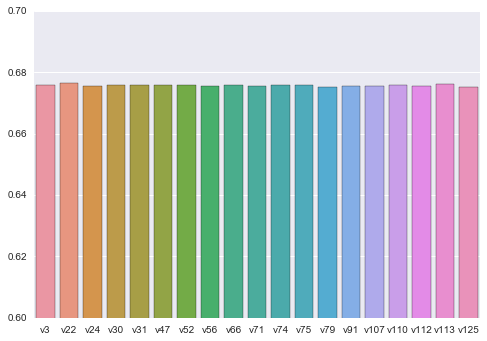

In [18]:
bar = sns.barplot(categorical_columns,best_scores)

axes = bar.axes

axes.set_ylim(0.6,0.7)
